In [1]:
%cd ../scripts
from backwardselim import back_ward_elim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm
import re

/mnt/c/Users/ohanr/OneDrive/Unimelb/3rd Year/MAST30034/generic-real-estate-consulting-project-group-25/scripts


# Preparing data

Reading + Merging

In [2]:
data = pd.read_csv("../data/curated/listings_with_distances.csv")
#school = pd.read_csv("../data/curated/Closest_and_average_dist_school.csv")
neighbour = pd.read_csv("../data/curated/neigh_stat.csv")

In [3]:
#data = pd.merge(data, school, left_on='id', right_on='listing_id')
data = pd.merge(data, neighbour, left_on='id', right_on='id')

Extracting suburb from the address

In [ ]:
def get_Suburb(x:str):
    try:
        suburb = re.findall(", [A-Za-z ]+ VIC", x)[0]
        suburb = re.sub(", || VIC", "", suburb)
    except IndexError:
        suburb = None
    return suburb
data["Suburb"] = data["address"].apply(lambda x: get_Suburb(x))

In [ ]:
data.to_csv("../data/curated/listings_with_distances.csv", index = False)

# Visualisation the relationships/correlations between each features and rental prices

In [4]:
COLS = ["price", "Suburb", "beds","propertyType", "closest_school", "dist_closest_school","ave_dist_3_schools", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestShop", "ClosestDstToStation", "ClosestStation", "ClosestDstToUni", "ClosestUni", "age0To19", "age20To39", "age40To59","age60Plus","longTermResident","owner","renter","family","single"]
CORR_COLS = ["price", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestDstToStation", "ClosestDstToUni", "dist_closest_school","ave_dist_3_schools", "age0To19", "age20To39", "age40To59","age60Plus","longTermResident","owner","renter","family","single"]
DISCRETE_COLS = ["Suburb", "closest_school", "ClosestShop", "ClosestStation", "ClosestUni"]
data = data[COLS]

Making sure to omit data where the distance was found to be too far, as it is not feasible to assume that the residents will utilise these facilities, and hence is considered irrelevant to determine the rental prices 

In [5]:
data = data[data['ClosestDstToShoppingCentre'] < 100000]
data = data[data['ClosestDstToStation'] < 100000]
data = data[data['DstToCBD'] < 100000] 
data = data[data['ClosestDstToUni'] < 100000]


In [6]:
bed_4_house = data[(data["beds"] == 4) & (data["propertyType"] == "House")]
bed_3_house = data[(data["beds"] == 3) & (data["propertyType"] == "House")]
bed_2_house = data[(data["beds"] == 2) & (data["propertyType"] == "House")]
bed_3_flat = data[(data["beds"] == 3) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_2_flat = data[(data["beds"] == 2) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_1_flat = data[(data["beds"] == 1) & (data["propertyType"] == "Apartment / Unit / Flat")]

Starting off with examining the correlations

In [7]:
bed_2_house[CORR_COLS].corr()

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools,age0To19,age20To39,age40To59,age60Plus,longTermResident,owner,renter,family,single
price,1.000000,-0.138925,-0.408367,-0.126302,-0.217497,-0.153683,-0.200081,-0.183551,0.145408,0.115008,-0.087118,-0.173898,-0.117073,0.133416,-0.001700,0.030221
ClosestDstToShoppingCentre,-0.138925,1.000000,0.307608,0.064303,0.377016,0.292720,0.413751,0.190383,-0.252246,0.046965,0.140620,0.060817,0.224956,-0.243671,0.194753,-0.227738
DstToCBD,-0.408367,0.307608,1.000000,0.511912,0.668923,0.285985,0.426707,0.223108,-0.391107,-0.125218,0.373756,0.117595,0.250376,-0.279366,0.095501,-0.146264
ClosestDstToStation,-0.126302,0.064303,0.511912,1.000000,0.676988,0.324731,0.398579,0.014124,-0.225226,-0.100589,0.326736,0.068553,0.154922,-0.166872,0.048218,-0.068273
ClosestDstToUni,-0.217497,0.377016,0.668923,0.676988,1.000000,0.352473,0.474314,0.113320,-0.350300,-0.069700,0.359396,0.050880,0.189414,-0.225804,0.053371,-0.118723
dist_closest_school,-0.153683,0.292720,0.285985,0.324731,0.352473,1.000000,0.745145,0.033232,-0.111815,-0.049761,0.059461,0.016302,0.142830,-0.194020,0.101386,-0.195896
ave_dist_3_schools,-0.200081,0.413751,0.426707,0.398579,0.474314,0.745145,1.000000,0.091141,-0.184145,-0.037378,0.131515,0.077279,0.210060,-0.248416,0.147867,-0.217514
age0To19,-0.183551,0.190383,0.223108,0.014124,0.113320,0.033232,0.091141,1.000000,-0.614197,0.476894,-0.066543,0.387089,0.639643,-0.583394,0.639241,-0.528406
age20To39,0.145408,-0.252246,-0.391107,-0.225226,-0.350300,-0.111815,-0.184145,-0.614197,1.000000,-0.381778,-0.584225,-0.542837,-0.701263,0.762951,-0.494054,0.601979
age40To59,0.115008,0.046965,-0.125218,-0.100589,-0.069700,-0.049761,-0.037378,0.476894,-0.381778,1.000000,-0.161428,0.320026,0.395983,-0.289893,0.469594,-0.267946


In [8]:
bed_1_flat[CORR_COLS].corr()

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools,age0To19,age20To39,age40To59,age60Plus,longTermResident,owner,renter,family,single
price,1.000000,-0.164556,-0.216769,-0.057354,-0.141203,-0.036544,-0.060735,-0.267730,0.182535,-0.079456,-0.105997,-0.241700,-0.163187,0.162129,-0.093171,0.092046
ClosestDstToShoppingCentre,-0.164556,1.000000,0.397456,0.233840,0.433076,0.135500,0.264931,0.302995,-0.354058,0.186814,0.356786,0.312007,0.292161,-0.288537,0.240895,-0.236114
DstToCBD,-0.216769,0.397456,1.000000,0.387979,0.625735,0.162958,0.269985,0.412016,-0.412467,0.145866,0.410064,0.372432,0.390691,-0.393557,0.236567,-0.241745
ClosestDstToStation,-0.057354,0.233840,0.387979,1.000000,0.383528,0.281504,0.431730,0.166797,-0.253543,0.135994,0.288484,0.167592,0.185415,-0.185874,0.151460,-0.152474
ClosestDstToUni,-0.141203,0.433076,0.625735,0.383528,1.000000,0.165768,0.258337,0.314685,-0.396301,0.222947,0.400567,0.335076,0.311979,-0.312175,0.200909,-0.201940
dist_closest_school,-0.036544,0.135500,0.162958,0.281504,0.165768,1.000000,0.759795,0.106282,-0.165963,0.090943,0.168660,0.085428,0.179619,-0.191148,0.109967,-0.127315
ave_dist_3_schools,-0.060735,0.264931,0.269985,0.431730,0.258337,0.759795,1.000000,0.179328,-0.237016,0.151844,0.221075,0.173453,0.224550,-0.230743,0.171158,-0.180689
age0To19,-0.267730,0.302995,0.412016,0.166797,0.314685,0.106282,0.179328,1.000000,-0.824004,0.613944,0.463706,0.721953,0.779530,-0.767072,0.699020,-0.682002
age20To39,0.182535,-0.354058,-0.412467,-0.253543,-0.396301,-0.165963,-0.237016,-0.824004,1.000000,-0.781275,-0.799242,-0.736663,-0.774459,0.785745,-0.747322,0.764940
age40To59,-0.079456,0.186814,0.145866,0.135994,0.222947,0.090943,0.151844,0.613944,-0.781275,1.000000,0.400192,0.470696,0.543330,-0.524845,0.723669,-0.696706


In [9]:
bed_2_flat[CORR_COLS].corr()

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools,age0To19,age20To39,age40To59,age60Plus,longTermResident,owner,renter,family,single
price,1.000000,-0.203616,-0.364182,-0.118946,-0.250868,-0.116821,-0.173662,-0.406739,0.349316,-0.221782,-0.222835,-0.365526,-0.260458,0.244151,-0.241634,0.224683
ClosestDstToShoppingCentre,-0.203616,1.000000,0.355986,0.173660,0.458121,0.109265,0.271501,0.334825,-0.341944,0.229372,0.269245,0.278984,0.331075,-0.324556,0.278019,-0.259592
DstToCBD,-0.364182,0.355986,1.000000,0.398488,0.680275,0.228345,0.374739,0.388002,-0.457938,0.189739,0.461146,0.359446,0.361832,-0.357214,0.241364,-0.240131
ClosestDstToStation,-0.118946,0.173660,0.398488,1.000000,0.435758,0.254651,0.396589,0.172870,-0.236215,0.108871,0.255839,0.175424,0.219052,-0.231105,0.177868,-0.177630
ClosestDstToUni,-0.250868,0.458121,0.680275,0.435758,1.000000,0.196759,0.369548,0.312026,-0.377574,0.217565,0.358551,0.255912,0.268534,-0.261781,0.193985,-0.184105
dist_closest_school,-0.116821,0.109265,0.228345,0.254651,0.196759,1.000000,0.711220,0.109947,-0.165912,0.047323,0.126725,0.100614,0.132633,-0.187661,0.098214,-0.162240
ave_dist_3_schools,-0.173662,0.271501,0.374739,0.396589,0.369548,0.711220,1.000000,0.227381,-0.258594,0.143006,0.190368,0.192537,0.231801,-0.266115,0.189962,-0.214495
age0To19,-0.406739,0.334825,0.388002,0.172870,0.312026,0.109947,0.227381,1.000000,-0.809604,0.638036,0.455526,0.711990,0.756277,-0.718180,0.718661,-0.627382
age20To39,0.349316,-0.341944,-0.457938,-0.236215,-0.377574,-0.165912,-0.258594,-0.809604,1.000000,-0.712692,-0.766250,-0.760323,-0.752615,0.784748,-0.711285,0.754274
age40To59,-0.221782,0.229372,0.189739,0.108871,0.217565,0.047323,0.143006,0.638036,-0.712692,1.000000,0.362198,0.499983,0.532042,-0.467267,0.709001,-0.589147


Followed by plotting to examine the details fo the relationship

/home/ohanr/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 1000.0)

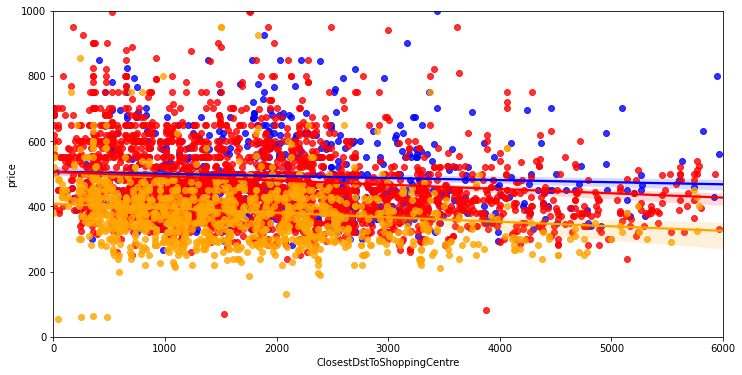

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot("ClosestDstToShoppingCentre", "price", color="blue", data=bed_2_house)
sns.regplot("ClosestDstToShoppingCentre", "price", color="red", data=bed_2_flat)
sns.regplot("ClosestDstToShoppingCentre", "price", color="orange", data=bed_1_flat)
plt.xlim(0, 6000)
plt.ylim(0, 1000)

(0.0, 1000.0)

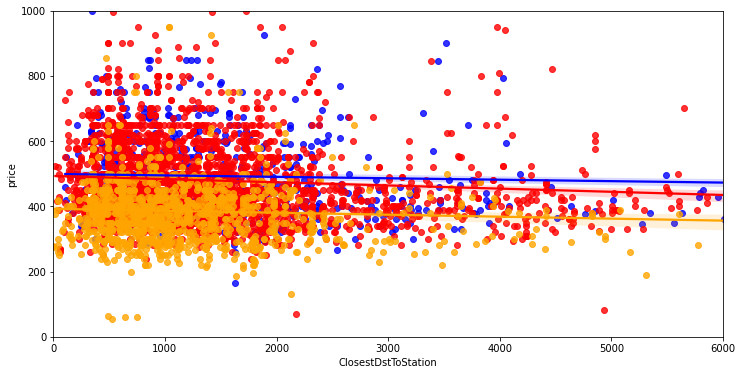

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot("ClosestDstToStation", "price", color="blue", data=bed_2_house)
sns.regplot("ClosestDstToStation", "price", color="red", data=bed_2_flat)
sns.regplot("ClosestDstToStation", "price", color="orange", data=bed_1_flat)
plt.xlim(0, 6000)
plt.ylim(0, 1000)

## ANOVAS

Removing outliers for each suburb

In [7]:
import math
def remove_outlier(dataframe):
    """
    Removes outlier in a dataframe
    Outliers are identified as any records outside of [mean-2*standard dev, mean+2*standard dev] of the data
    """
    df = pd.DataFrame()
    for suburb in dataframe["Suburb"].unique():
        prices = dataframe[dataframe["Suburb"] == suburb]["price"]
        if len(prices) > 0:
            mean = prices.sum()/len(prices)
            sd = math.sqrt(((prices-mean)*(prices-mean)).sum()/(len(prices)))
            df = pd.concat([df, dataframe[(dataframe.Suburb == suburb) & (dataframe.price < mean + 2*sd) & (dataframe.price > mean - 2*sd)]])
    return df


In [8]:
bed_1_flat_clean = remove_outlier(bed_1_flat)
bed_2_flat_clean = remove_outlier(bed_2_flat)
bed_2_house_clean = remove_outlier(bed_2_house)

### Backward elimination

To test which features are the most significant in determining the price of the listing at instance level, and see how much of the variance in rental prices can be explained by these features

In [ ]:
bed_1_flat_anova, bed_1_flat_model = back_ward_elim(bed_1_flat_clean)
bed_2_flat_anova, bed_2_flat_model = back_ward_elim(bed_2_flat_clean)
bed_2_house_anova, bed_2_house_model = back_ward_elim(bed_2_house_clean)

In [23]:
bed_1_flat_anova

,sum_sq,df,F,PR(>F)
Suburb,6.885844e+05,99.0,2.094602,3.738628e-08
closest_school,1.613181e+06,264.0,1.840174,1.919313e-10
ave_dist_3_schools,3.094163e+04,1.0,9.318002,2.352522e-03
Residual,2.394174e+06,721.0,NaN,NaN


In [24]:
bed_2_flat_anova

,sum_sq,df,F,PR(>F)
Suburb,2.203627e+06,189.0,2.125201,6.579525e-15
closest_school,4.741030e+06,558.0,1.548682,2.642380e-11
age0To19,7.436388e+04,1.0,13.554573,2.390201e-04
age20To39,6.508158e+04,1.0,11.862655,5.867218e-04
owner,2.716764e+04,1.0,4.951945,2.619311e-02
Residual,9.255316e+06,1687.0,NaN,NaN


In [25]:
bed_2_house_anova

,sum_sq,df,F,PR(>F)
Suburb,4.834709e+06,121.0,5.379493,1.956836e-24
closest_school,6.002247e+06,300.0,2.693699,1.018226e-12
Residual,1.351808e+06,182.0,NaN,NaN


In [16]:
bed_1_flat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     4.425
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           5.07e-62
Time:                        13:05:34   Log-Likelihood:                -5534.8
No. Observations:                1047   AIC:                         1.172e+04
Df Residuals:                     721   BIC:                         1.334e+04
Df Model:                         325                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                        110.3488    155.772      0.708      0.479    -195.471     416.169
Suburb[T.Albert Park]                                                                                            136.9922     80.229      1.708      0.088     -20.517     294.502
Suburb[T.Alphington]                                                                                             109.2459    120.970      0.903      0.367    -128.250     346.741
Suburb[T.Altona]                                                                                                 156.1347     97.104      1.608      0.108     -34.505     346.775
Suburb[T.Armadale]                                                                                               113.5455     98.876      1.148      0.251     -80.573     307.665
Suburb[T.Ascot Vale]                                                                                             -63.8044    117.594     -0.543      0.588    -294.673     167.064
Suburb[T.Balaclava]                                                                                              111.5025     80.343      1.388      0.166     -46.232     269.237
Suburb[T.Bentleigh]                                                                                              148.5071    106.957      1.388      0.165     -61.477     358.491
Suburb[T.Blackburn]                                                                                              102.7099     79.352      1.294      0.196     -53.079     258.499
Suburb[T.Box Hill]                                                                                               115.3860    117.600      0.981      0.327    -115.493     346.265
Suburb[T.Brighton]                                                                                               205.5655    126.260      1.628      0.104     -42.316     453.447
Suburb[T.Brunswick]                                                                                               44.3963    112.341      0.395      0.693    -176.159     264.952
Suburb[T.Brunswick East]                                                                                          11.0056    121.418      0.091      0.928    -227.369     249.381
Suburb[T.Brunswick West]                                                                                          66.5982     95.916      0.694      0.488    -121.711     254.907
Suburb[T.Bundoora]                      

In [17]:
bed_2_flat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     5.471
Date:                Sun, 16 Oct 2022   Prob (F-statistic):          9.92e-176
Time:                        13:05:46   Log-Likelihood:                -13128.
No. Observations:                2363   AIC:                         2.761e+04
Df Residuals:                    1687   BIC:                         3.151e+04
Df Model:                         675                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================================
                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                              668.8841     76.978      8.689      0.000     517.902     819.866
Suburb[T.Aberfeldie]                                                                                                   -98.3612     42.932     -2.291      0.022    -182.566     -14.156
Suburb[T.Albert Park]                                                                                                  276.5920    115.276      2.399      0.017      50.494     502.690
Suburb[T.Alphington]                                                                                                  -226.1424    105.441     -2.145      0.032    -432.951     -19.334
Suburb[T.Altona]                                                                                                      -314.7198     88.782     -3.545      0.000    -488.855    -140.585
Suburb[T.Altona Meadows]                                                                                              -142.6959     61.693     -2.313      0.021    -263.699     -21.693
Suburb[T.Ardeer]                                                                                                      -137.6889     58.056     -2.372      0.018    -251.559     -23.819
Suburb[T.Armadale]                                                                                                    -223.1669     88.116     -2.533      0.011    -395.995     -50.339
Suburb[T.Ascot Vale]                                                                                                  -312.7580     88.180     -3.547      0.000    -485.712    -139.804
Suburb[T.Aspendale]                                                                                                   -149.5902     57.155     -2.617      0.009    -261.692     -37.488
Suburb[T.Balaclava]                                                                                                    -78.0787    128.965     -0.605      0.545    -331.028     174.870
Suburb[T.Balwyn]                                                                                                      -133.6730    148.288     -0.901      0.367    -424.520     157.174
Suburb[T.Balwyn North]                                                                                                -207.2545    113.347     -1.828      0.068    -429.570      15.061
Suburb[T.Bell Post Hill]                                                                                              -137.

In [18]:
bed_2_house_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     3.091
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           5.07e-16
Time:                        13:06:08   Log-Likelihood:                -2767.7
No. Observations:                 517   AIC:                             6205.
Df Residuals:                     182   BIC:                             7629.
Df Model:                         334                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                        675.0000     86.183      7.832      0.000     504.954     845.046
Suburb[T.Albert Park]                                                                                             53.3333     64.237      0.830      0.407     -73.412     180.078
Suburb[T.Altona]                                                                                                -151.2672    138.046     -1.096      0.275    -423.643     121.109
Suburb[T.Altona Meadows]                                                                                        -222.9167     72.534     -3.073      0.002    -366.032     -79.801
Suburb[T.Altona North]                                                                                          -166.6667     70.368     -2.368      0.019    -305.509     -27.824
Suburb[T.Armadale]                                                                                               -76.2500     74.637     -1.022      0.308    -223.514      71.014
Suburb[T.Ascot Vale]                                                                                             -80.9375     90.774     -0.892      0.374    -260.042      98.167
Suburb[T.Avondale Heights]                                                                                      -142.5000     52.776     -2.700      0.008    -246.632     -38.368
Suburb[T.Bentleigh]                                                                                               -5.0000     74.637     -0.067      0.947    -152.264     142.264
Suburb[T.Blackburn South]                                                                                       -180.0000     70.368     -2.558      0.011    -318.842     -41.158
Suburb[T.Box Hill]                                                                                              -215.0000     95.279     -2.257      0.025    -402.993     -27.007
Suburb[T.Box Hill North]                                                                                        -145.0000     81.254     -1.785      0.076    -305.321      15.321
Suburb[T.Box Hill South]                                                                                        -206.5000     79.457     -2.599      0.010    -363.275     -49.725
Suburb[T.Braybrook]                                                                                             -275.6135    129.189     -2.133      0.034    -530.514     -20.713
Suburb[T.Brighton]                      